# Preprocessing, building a Pandas dataframe and saving it as a  .csv file

In [1]:
import email, glob
import pandas as pd
from flanker import mime
import string
import re
import numpy as np
from collections import Counter, OrderedDict

from pprint import pprint
import sys
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')
import seaborn as sns

%matplotlib inline


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

%matplotlib inline

fpath = "/home/niki/Documents/BE_Project/my_EmailRecommmendation/features/Dataset/*/*.email"
folder_path = "/home/niki/Documents/BE_Project/my_EmailRecommmendation/features/Dataset/*"
file_name = "/home/niki/Documents/BE_Project/my_EmailRecommmendation/model/dataframe.csv"

def remove_content_in_braces(msg) :
	msg1 = ''
	cnt = 0
	for char in msg :
		if char == '{' :
			cnt += 1
		elif char == '}' :
			cnt -= 1
		elif cnt == 0 :
			msg1 += char
		else :
			continue
	return msg1

def remove_func_and_struct(msg) :
	msg1 = ''
	take_line = True
	msg = msg.splitlines()
	for line in msg :
		take_line = True
		if line == '' :
			continue
		words = line.split(' ')
		if words[0] == "func" :
			take_line = False
		elif words[0] == "type" :
			if len(words)  >= 3  and words[2] == "struct" :
				take_line = False
		if take_line :
			msg1 += (line + '\n')
	return msg1

def remove_other_code_lines(msg) :
	msg1 = ''
	take_line = True
	msg = msg.splitlines()
	i = 0	
	while i < len(msg) :
		if (msg[i] == '') or ("//" in msg[i]) :
			i += 1
			continue
		take_line = True
		line = msg[i]
		if "package" in line :
			words = line.split(' ')
			if len(words) < 4 :
				take_line = False
		elif "import" in line :
			words = line.split(' ')
			if len(words) < 4 :
				take_line = False
				if "(" in line :
					while ')' not in msg[i] :
						i += 1
		elif "const" in line :
			words = line.split(' ')
			if len(words) < 4 :
				take_line = False
				if "(" in line :
					while ')' not in msg[i] :
						i += 1
		if take_line :
			msg1 += line + '\n'
		i += 1
	return msg1


def remove_code(msg) :
	msg = (remove_content_in_braces(msg))
	msg = (remove_func_and_struct(msg))
	msg = (remove_other_code_lines(msg))
	return msg

def get_sender(msg):
    msg = email.message_from_string(msg)
    mfrom = msg['From'].split('<')[0]
    return mfrom
    
def flan(msg):
    rt = ''
    msg = mime.from_string(msg)
    if msg.content_type.is_singlepart():
      temp = str(msg.body)
      temp = temp.splitlines()
      for _ in temp:
          if _.startswith('>'):
              continue
          elif _.startswith('On'):
              continue
          else:
              rt+=_+"\n"
    else :
      for part in msg.parts :
          if "(text/plain)" in str(part) :
              temp = str(part.body)
              temp = temp.splitlines()
              for _ in temp :
                  if _.startswith('>') :
                      continue
                  if _.startswith('On'):
                      continue
                  else :
                      rt+=_+"\n"
    return rt

df = pd.DataFrame(columns=['body','replier', 'thread_no'])
users = []
folder = glob.glob(folder_path)
th_no = 0

for fol in folder:
    files = glob.glob(fol+'/*.email')
    flag = 0
    t = ''
    for file in files:
        if flag==0:
            dataa = open(file,'r')
            temp = dataa.read()
            sender = get_sender(temp)
            temp = flan(temp)
            temp = remove_code(temp)
            temp = re.sub('\n+','\n',temp)
            temp = re.sub('\n',' ',temp)
            temp = re.sub('\t',' ',temp)
            temp = re.sub(' +',' ',temp)
#             print(temp)
            t = temp
            flag = 1
            users.append(sender)
            
            continue
        dataa = open(file,'r')
        temp = dataa.read()
        sender = get_sender(temp)
        users.append(sender)
        temp = flan(temp)
        temp = remove_code(temp)
        temp = re.sub('\n+','\n',temp)
        temp = re.sub('\n',' ',temp)
        temp = re.sub('\t',' ',temp)
        temp = re.sub(' +',' ',temp)
#         print(temp)
        df = df.append({'body': str(t),'replier':sender, 'thread_no':th_no}, ignore_index=True)
        t = t + temp
    th_no += 1

# print(df.head)

rep_to_index = {}
count = 0
for rep in df['replier']:
    if rep in rep_to_index:
        continue
    else:
        rep_to_index[rep] = count
        count += 1
pprint(len(rep_to_index))
for rep in df['replier']:
    df.loc[df['replier']==rep,'replier'] = rep_to_index[rep]
# print(df.head)
df.to_csv(file_name)
unique_users = len(df.replier.unique())

32


In [2]:
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])

In [3]:
df['body'] = df.body.apply(lambda z:z.strip())

In [4]:
words = Counter()
for sent in tqdm_notebook(df.body.values):
    words.update(w.text.lower() for w in nlp(sent))

HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

In [5]:
len(words)
# words.most_common(20)
words = sorted(words, key=words.get, reverse=True)
# words[:20]
words = ['_PAD','_UNK'] + words
# words[:10]

1180

In [6]:
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}
def indexer(s): return [word2idx[w.text.lower()] for w in nlp(s)]

In [7]:
%%time
df['bodyidx'] = df.body.apply(indexer)
df.head()

CPU times: user 366 ms, sys: 41 µs, total: 366 ms
Wall time: 365 ms


In [8]:
df['lengths'] = df.bodyidx.apply(len)
df.head()

,body,replier,thread_no,bodyidx,lengths
0,I have client and server. --- Client type Args...,0,0,"[7, 24, 683, 13, 417, 2, 167, 683, 63, 817, 19...",96
1,I'm looking at the math package and I'm not se...,1,1,"[7, 184, 823, 61, 5, 597, 50, 13, 7, 184, 25, ...",44
2,I'm looking at the math package and I'm not se...,2,1,"[7, 184, 823, 61, 5, 597, 50, 13, 7, 184, 25, ...",53
3,"once you get the whole request, you can then u...",3,2,"[831, 17, 121, 5, 598, 832, 6, 17, 41, 108, 97...",37
4,"once you get the whole request, you can then u...",4,2,"[831, 17, 121, 5, 598, 832, 6, 17, 41, 108, 97...",70


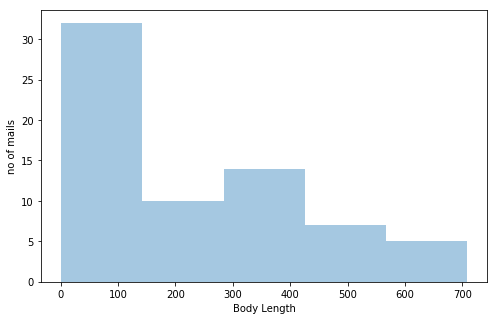

In [75]:
fig = plt.figure(figsize=(8,5))
ax = sns.distplot(df.lengths.values,kde=False);
ax.set(xlabel='Body Length', ylabel='no of mails');

# Dataset Loading

In [10]:
class VectorizeData(Dataset):
    def __init__(self, df_path, maxlen=10):
        self.maxlen = maxlen
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['body'] = self.df.body.apply(lambda x: x.strip())
        print('Indexing...')
        self.df['bodyidx'] = self.df.body.progress_apply(indexer)
        print('Calculating lengths')
        self.df['lengths'] = self.df.bodyidx.progress_apply(lambda x: self.maxlen if len(x) > self.maxlen else len(x))
        print('Padding')
        self.df['bodypadded'] = self.df.bodyidx.progress_apply(self.pad_data)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.bodypadded[idx]
        lens = self.df.lengths[idx]
        y = self.df.replier[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded

In [11]:
print(max(df['lengths']))
ds = VectorizeData(file_name,max(df['lengths']))

Progress:  25%|██▌       | 17/68 [00:00<00:00, 167.92it/s]

708
Indexing...


Progress: 100%|██████████| 68/68 [00:00<00:00, 36561.04it/s]

Calculating lengths
Padding


In [12]:
dl = DataLoader(ds, batch_size=1)
print('Total batches', len(dl))

Total batches 68


In [13]:
print(ds[:])
it = iter(dl)
xs,ys,lens =  next(it)
# for itt in iter(dl):
# #     xs,ys,lens =  next(itt)
#     print(itt[1])

print(type(ys))
print(ys)
print('Labels:',ys)
print('Lengths:',lens)

(0     [7, 24, 683, 13, 417, 2, 167, 683, 63, 817, 19...
1     [7, 184, 823, 61, 5, 597, 50, 13, 7, 184, 25, ...
2     [7, 184, 823, 61, 5, 597, 50, 13, 7, 184, 25, ...
3     [831, 17, 121, 5, 598, 832, 6, 17, 41, 108, 97...
4     [831, 17, 121, 5, 598, 832, 6, 17, 41, 108, 97...
5     [7, 836, 16, 19, 14, 837, 988, 7, 276, 104, 98...
6     [19, 14, 484, 61, 5, 485, 6, 28, 132, 46, 486,...
7     [19, 14, 484, 61, 5, 485, 6, 28, 132, 46, 486,...
8     [19, 14, 484, 61, 5, 485, 6, 28, 132, 46, 486,...
9     [19, 14, 484, 61, 5, 485, 6, 28, 132, 46, 486,...
10    [19, 14, 484, 61, 5, 485, 6, 28, 132, 46, 486,...
11    [5, 65, 351, 352, 137, 23, 71, 10, 353, 5, 175...
12    [5, 65, 351, 352, 137, 23, 71, 10, 353, 5, 175...
13    [5, 65, 351, 352, 137, 23, 71, 10, 353, 5, 175...
14    [5, 65, 351, 352, 137, 23, 71, 10, 353, 5, 175...
15    [5, 65, 351, 352, 137, 23, 71, 10, 353, 5, 175...
16    [5, 65, 351, 352, 137, 23, 71, 10, 353, 5, 175...
17    [5, 65, 351, 352, 137, 23, 71, 10, 353, 5

In [71]:
input_size = max(df['lengths'])
hidden_size = 25
num_classes = unique_users
num_epochs = 25
batch_size = 1
learning_rate = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# print(len(words))

In [72]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
#         x = torch.FloatTensor(x)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [73]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [74]:
train_dl= DataLoader(ds, batch_size=1)
num_batch = len(train_dl)
for epoch in range(num_epochs):
    y_true_train = list()
    y_pred_train = list()
    total_loss_train = 0
    t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
    for X,y, lengths in t:
    #     X = X.transpose(0,1)
        X = Variable(X.cpu())
        y = Variable(y.cpu())
        lengths = lengths.numpy()

        opt.zero_grad()
        X = X.float()
        pred = model(X)
        loss = F.nll_loss(pred, y)
        loss.backward()
        opt.step()

        t.set_postfix(loss=loss.data[0])
        pred_idx = torch.max(pred, dim=1)[1]

        y_true_train += list(y.cpu().data.numpy())
        y_pred_train += list(pred_idx.cpu().data.numpy())
        total_loss_train += loss.data[0]

    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_loss = total_loss_train/len(train_dl)
    print(f' Epoch {epoch}: Train loss: {train_loss} acc: {train_acc}')

HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 0: Train loss: -442.1465759277344 acc: 0.014705882352941176


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 1: Train loss: -10163.96484375 acc: 0.08823529411764706


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 2: Train loss: -66739.1875 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 3: Train loss: -217089.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 4: Train loss: -480580.8125 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 5: Train loss: -856050.625 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 6: Train loss: -1337775.375 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 7: Train loss: -1920411.625 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 8: Train loss: -2599521.25 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 9: Train loss: -3371380.75 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 10: Train loss: -4232779.5 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 11: Train loss: -5180885.5 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 12: Train loss: -6213156.5 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 13: Train loss: -7327273.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 14: Train loss: -8521096.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 15: Train loss: -9792643.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 16: Train loss: -11140063.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 17: Train loss: -12561620.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 18: Train loss: -14055676.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 19: Train loss: -15620697.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 20: Train loss: -17255216.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 21: Train loss: -18957856.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 22: Train loss: -20727302.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 23: Train loss: -22562320.0 acc: 0.10294117647058823


HBox(children=(IntProgress(value=0, max=68), HTML(value='')))

 Epoch 24: Train loss: -24461722.0 acc: 0.10294117647058823


In [ ]:

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')